In [1]:
# Cell 1: Imports and display configuration
from pathlib import Path
from datetime import datetime
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

# High DPI figures in notebooks
%config InlineBackend.figure_format = 'retina'

pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(200)


polars.config.Config

In [2]:
# Cell 2: Parameters
LAKE_ROOT = Path("/home/dev/data/ohlcv")

asset_class = "crypto"   # one of: crypto, fx, index, etf, equity, futures
symbol = "ETH"           # e.g., ETH, BTC, USDJPY, SPY, AAPL
freq = "15min"           # one of: 1min, 15min, 1h, 4h, 1d

# Optional partition narrowing
year = 2025              # set to None to read all years
month = 7                # set to None to read all months

# Optional lazy-scan date filter window (UTC)
date_start = pd.Timestamp("2024-01-01", tz="UTC")
date_end   = pd.Timestamp("2024-04-01", tz="UTC")


In [13]:
# Drop-in replacement for read_parquet_hive (Polars-friendly)
from pathlib import Path
from typing import Union, Optional, Any, List
import polars as pl

def read_parquet_hive(
    root_path: Union[str, Path],
    *,
    asset_class: str,
    symbol: str,
    freq: str,
    year: Optional[int] = None,
    month: Optional[int] = None,
    columns: Optional[List[str]] = None,
    **kwargs: Any,
) -> pl.DataFrame:
    """
    Reads OHLCV data from a hive-partitioned Parquet lake with Polars.
    Ensures `ts` is timezone-aware in UTC and places it as the first column.
    """
    base_path = Path(root_path) / f"asset_class={asset_class}" / f"freq={freq}" / f"symbol={symbol}"

    # Build path pattern
    if year is not None and month is not None:
        search_path = base_path / f"year={year}" / f"month={month:02d}"
    elif year is not None:
        search_path = base_path / f"year={year}"
    else:
        search_path = base_path

    # Always include ts if columns filtering was requested
    read_cols = columns
    if read_cols is not None and "ts" not in read_cols:
        read_cols = ["ts"] + [c for c in read_cols]

    df = pl.read_parquet(
        str(search_path),
        hive_partitioning=True,
        columns=read_cols,
        **kwargs,
    )

    if "ts" in df.columns:
        ts_dtype = df.schema["ts"]
        dtype_name = ts_dtype.__class__.__name__  # "Utf8" or "Datetime", etc.

        if dtype_name == "Utf8":
            # Parse strings to timezone-aware UTC
            df = df.with_columns(
                pl.col("ts").str.to_datetime(time_zone="UTC", strict=False)
            )
        elif dtype_name == "Datetime":
            # Determine if tz is set on the dtype
            tz = getattr(ts_dtype, "time_zone", None)
            if tz is None:
                # Naive -> mark as UTC
                df = df.with_columns(pl.col("ts").dt.replace_time_zone("UTC"))
            elif tz != "UTC":
                # Convert to UTC if needed
                df = df.with_columns(pl.col("ts").dt.convert_time_zone("UTC"))
        else:
            # Unexpected type: make a best-effort parse to UTC
            df = df.with_columns(
                pl.col("ts").cast(pl.Utf8).str.to_datetime(time_zone="UTC", strict=False)
            )

        # Put ts first without Pandas ops
        if df.columns[0] != "ts":
            df = df.select(["ts"] + [c for c in df.columns if c != "ts"])

    # Require OHLC; treat volume as optional since some indices may lack it
    required = {"open", "high", "low", "close"}
    missing = required.difference(df.columns)
    if missing:
        raise ValueError(f"Missing OHLC columns in loaded data: {', '.join(sorted(missing))}")

    return df


In [14]:
# Cell 4: Load a partition and sort
df = read_parquet_hive(
    LAKE_ROOT,
    asset_class=asset_class,
    symbol=symbol,
    freq=freq,
    year=year,
    month=month,
)
df = df.sort("ts")

df.head()


ts,open,high,low,close,volume,asset_class,symbol
"datetime[μs, UTC]",f64,f64,f64,f64,f64,str,str
2025-07-01 00:00:00 UTC,2486.16,2496.4,2485.38,2493.36,1151.93403,"""crypto""","""ETH"""
2025-07-01 00:15:00 UTC,2493.43,2498.5,2485.0,2485.15,650.784791,"""crypto""","""ETH"""
2025-07-01 00:30:00 UTC,2485.25,2490.5,2477.72,2489.4,1360.341981,"""crypto""","""ETH"""
2025-07-01 00:45:00 UTC,2489.47,2496.2,2489.3,2493.94,592.136844,"""crypto""","""ETH"""
2025-07-01 01:00:00 UTC,2493.89,2499.9,2491.0,2499.36,685.831934,"""crypto""","""ETH"""


In [10]:
# Inspect the ts dtype quickly
tmp = pl.read_parquet(
    str(Path(LAKE_ROOT) / f"asset_class={asset_class}" / f"freq={freq}" / f"symbol={symbol}" / "year=*" / "month=*" / "part.parquet"),
    hive_partitioning=True,
    n_rows=5,  # small sniff
)
display(tmp.schema)  # dict: column -> dtype


Schema([('ts', Datetime(time_unit='us', time_zone='UTC')),
        ('open', Float64),
        ('high', Float64),
        ('low', Float64),
        ('close', Float64),
        ('volume', Float64),
        ('asset_class', String),
        ('symbol', String),
        ('freq', String),
        ('year', Int64),
        ('month', Int64)])

In [15]:
# Cell 5: Basic profile
profile_tbl = pl.DataFrame(
    {
        "rows": [df.height],
        "from_ts": [df.get_column("ts").min()],
        "to_ts": [df.get_column("ts").max()],
    }
)
profile_tbl


rows,from_ts,to_ts
i64,"datetime[μs, UTC]","datetime[μs, UTC]"
2496,2025-07-01 00:00:00 UTC,2025-07-26 23:45:00 UTC


In [16]:
# Cell 6: Null counts for OHLCV
null_counts = df.select(
    [pl.col(c).is_null().sum().alias(c) for c in ["open", "high", "low", "close", "volume"]]
)
null_counts


open,high,low,close,volume
u32,u32,u32,u32,u32
0,0,0,0,0


In [17]:
# Cell 7: Schema snapshot
schema_tbl = pl.DataFrame(
    {"column": df.columns, "dtype": [str(t) for t in df.dtypes]}
)
schema_tbl


column,dtype
str,str
"""ts""","""Datetime(time_unit='us', time_…"
"""open""","""Float64"""
"""high""","""Float64"""
"""low""","""Float64"""
"""close""","""Float64"""
"""volume""","""Float64"""
"""asset_class""","""String"""
"""symbol""","""String"""


In [18]:
# Cell 8: Sanity checks for OHLCV constraints
violations = df.filter(
    (pl.col("low") > pl.col("high"))
    | (pl.max_horizontal("open", "close") > pl.col("high"))
    | (pl.min_horizontal("open", "close") < pl.col("low"))
    | (pl.col("open") <= 0)
    | (pl.col("high") <= 0)
    | (pl.col("low") <= 0)
    | (pl.col("close") <= 0)
    | (pl.col("volume") < 0)
)
violations.head(20)


ts,open,high,low,close,volume,asset_class,symbol
"datetime[μs, UTC]",f64,f64,f64,f64,f64,str,str


In [19]:
# Cell 9: Duplicate timestamp check
dupes = (
    df.group_by("ts")
      .len()
      .filter(pl.col("len") > 1)
      .sort("len", descending=True)
)
dupes.head(20)


ts,len
"datetime[μs, UTC]",u32


In [20]:
# Cell 10: Largest gaps between rows
step_seconds_map = {"1min": 60, "15min": 900, "1h": 3600, "4h": 14400, "1d": 86400}
expected_step = step_seconds_map.get(freq)

gaps = (
    df.select("ts")
      .with_columns(prev_ts=pl.col("ts").shift(1))
      .with_columns(delta_s=(pl.col("ts") - pl.col("prev_ts")).dt.total_seconds())
      .sort("delta_s", descending=True)
)

if expected_step is not None:
    gaps = gaps.with_columns(gap_factor=(pl.col("delta_s") / expected_step))

gaps.head(25)


ts,prev_ts,delta_s,gap_factor
"datetime[μs, UTC]","datetime[μs, UTC]",i64,f64
2025-07-01 00:00:00 UTC,null,null,null
2025-07-01 00:15:00 UTC,2025-07-01 00:00:00 UTC,900,1.0
2025-07-01 00:30:00 UTC,2025-07-01 00:15:00 UTC,900,1.0
2025-07-01 00:45:00 UTC,2025-07-01 00:30:00 UTC,900,1.0
2025-07-01 01:00:00 UTC,2025-07-01 00:45:00 UTC,900,1.0
2025-07-01 01:15:00 UTC,2025-07-01 01:00:00 UTC,900,1.0
2025-07-01 01:30:00 UTC,2025-07-01 01:15:00 UTC,900,1.0
2025-07-01 01:45:00 UTC,2025-07-01 01:30:00 UTC,900,1.0
2025-07-01 02:00:00 UTC,2025-07-01 01:45:00 UTC,900,1.0


In [21]:
# Cell 11: Lazy scan across all months with optional UTC window
scan_pattern = str(
    LAKE_ROOT
    / f"asset_class={asset_class}"
    / f"freq={freq}"
    / f"symbol={symbol}"
    / "year=*"
    / "month=*"
    / "part.parquet"
)

lf = pl.scan_parquet(scan_pattern, hive_partitioning=True)

lf_filtered = (
    lf.filter(pl.col("ts").is_between(pl.lit(date_start.to_pydatetime()), pl.lit(date_end.to_pydatetime())))
    if date_start is not None and date_end is not None
    else lf
)

slice_df = (
    lf_filtered
    .sort("ts")
    .limit(1000)
).collect()

slice_df.head()


ts,open,high,low,close,volume,asset_class,symbol,freq,year,month
"datetime[μs, UTC]",f64,f64,f64,f64,f64,str,str,str,i64,i64
2024-01-01 00:00:00 UTC,2282.17,2299.49,2281.27,2296.54,1462.727767,"""crypto""","""ETH""","""15min""",2024,1
2024-01-01 00:15:00 UTC,2297.0,2297.5,2280.62,2290.56,3102.885862,"""crypto""","""ETH""","""15min""",2024,1
2024-01-01 00:30:00 UTC,2290.87,2296.45,2285.39,2293.44,1720.700805,"""crypto""","""ETH""","""15min""",2024,1
2024-01-01 00:45:00 UTC,2293.4,2300.15,2292.17,2295.6,486.115193,"""crypto""","""ETH""","""15min""",2024,1
2024-01-01 01:00:00 UTC,2295.57,2300.95,2292.08,2296.77,720.149303,"""crypto""","""ETH""","""15min""",2024,1


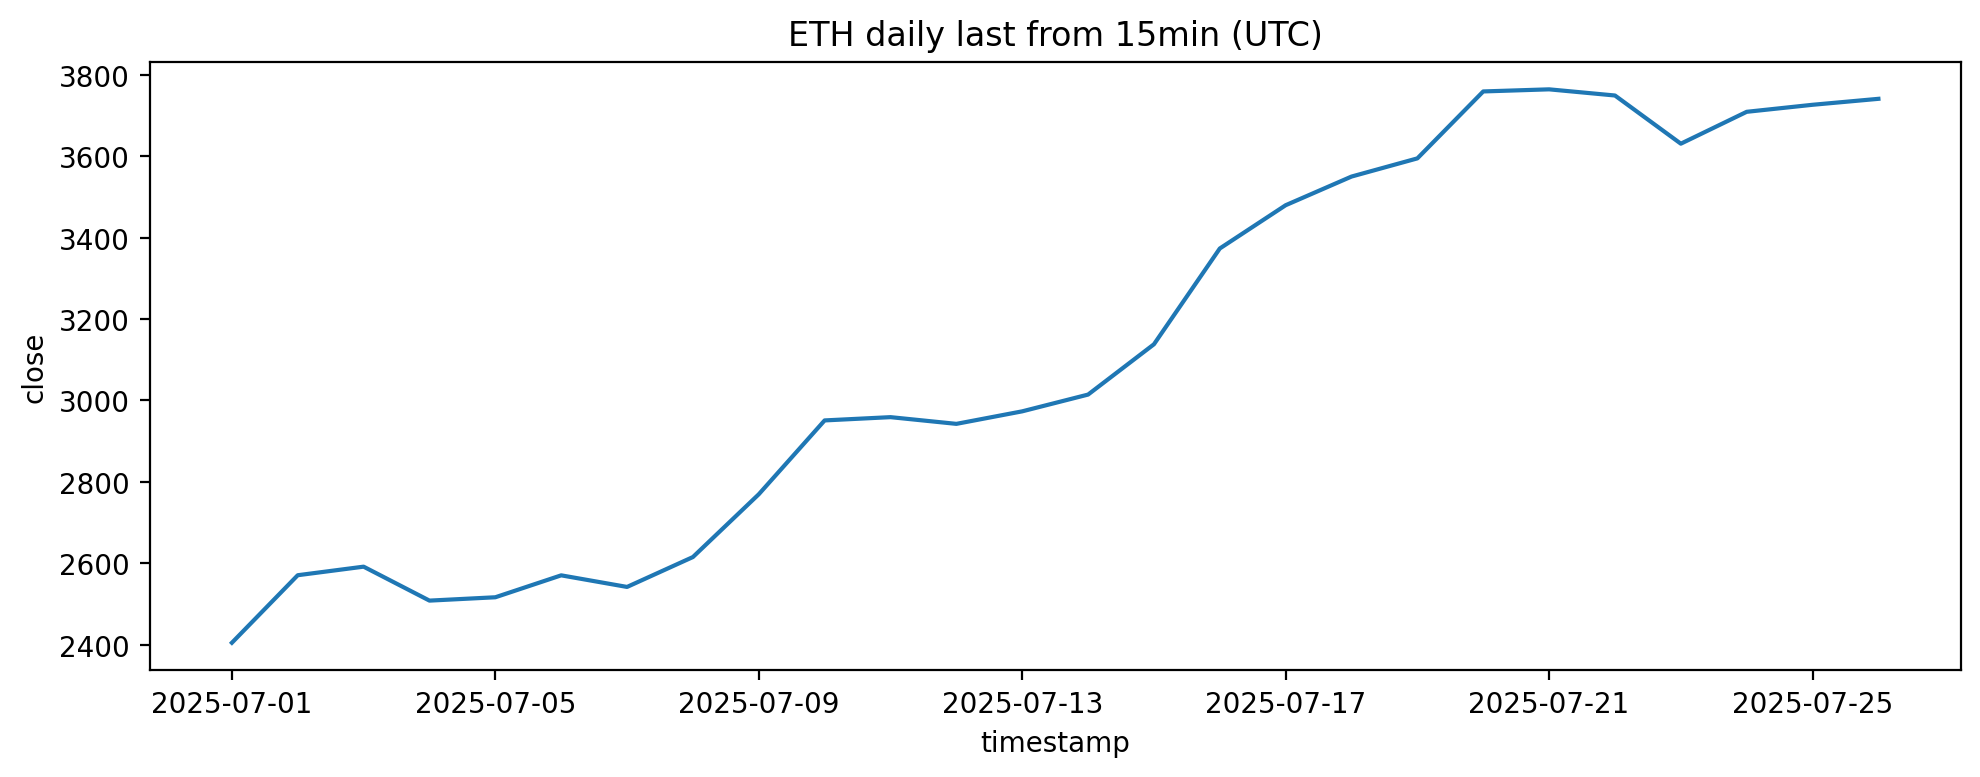

In [22]:
# Cell 12: Daily last close plot with correct anchor
# Crypto: daily anchored to UTC
# Non-crypto (fx, index, etf, equity, futures): daily anchored to America/New_York

def daily_last_from_intraday(frame: pl.DataFrame, asset_class: str) -> pl.DataFrame:
    if asset_class == "crypto":
        daily = (
            frame.group_by_dynamic(index_column="ts", every="1d", closed="left")
                 .agg(pl.col("close").last().alias("close"))
                 .sort("ts")
        )
        return daily
    else:
        # Convert to ET to anchor windowing, then convert labels back to UTC for consistency
        frame_et = frame.with_columns(pl.col("ts").dt.convert_time_zone("America/New_York"))
        daily_et = (
            frame_et.group_by_dynamic(index_column="ts", every="1d", closed="left")
                    .agg(pl.col("close").last().alias("close"))
                    .sort("ts")
        )
        daily = daily_et.with_columns(pl.col("ts").dt.convert_time_zone("UTC"))
        return daily

daily = daily_last_from_intraday(df, asset_class=asset_class)

# Plot
daily_pd = daily.to_pandas()
plt.figure(figsize=(10, 4))
plt.plot(daily_pd["ts"], daily_pd["close"])
plt.title(f"{symbol} daily last from {freq} ({'UTC' if asset_class=='crypto' else 'NY-anchored, labels UTC'})")
plt.xlabel("timestamp")
plt.ylabel("close")
plt.tight_layout()


In [24]:
import numpy as np

# Cell 13: Simple returns and rolling volatility diagnostics
# Computes log returns on close and a rolling 20-day volatility on the daily series

daily_pd = daily.to_pandas()  # already created above
daily_pd.set_index("ts", inplace=True)
daily_pd.index = pd.to_datetime(daily_pd.index, utc=True)

daily_pd["logret"] = (daily_pd["close"].astype("float64")).apply(pd.Series).pct_change().add(1).apply(np.log)  # robust log return
# Replace the above with a safer direct computation to avoid chained dtype issues:

close_values = daily_pd["close"].astype("float64").values
logret = np.empty_like(close_values)
logret[:] = np.nan
logret[1:] = np.log(close_values[1:] / close_values[:-1])
daily_pd["logret"] = logret

# 20-day rolling volatility (annualized, sqrt(252))
daily_pd["vol20"] = pd.Series(daily_pd["logret"]).rolling(20).std() * np.sqrt(252)

display(daily_pd[["close", "logret", "vol20"]].tail(20))


,close,logret,vol20
ts,,,
2025-07-07 00:00:00+00:00,2542.38,-0.011132,NaN
2025-07-08 00:00:00+00:00,2615.74,0.028446,NaN
2025-07-09 00:00:00+00:00,2769.83,0.057239,NaN
2025-07-10 00:00:00+00:00,2951.10,0.063392,NaN
2025-07-11 00:00:00+00:00,2959.12,0.002714,NaN
2025-07-12 00:00:00+00:00,2942.64,-0.005585,NaN
2025-07-13 00:00:00+00:00,2973.38,0.010392,NaN
2025-07-14 00:00:00+00:00,3014.53,0.013745,NaN
2025-07-15 00:00:00+00:00,3138.01,0.040145,NaN
